In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv('/Users/rampageyao/Desktop/tum/applied machine intelligence/project/elec_forecast.csv')

Price = data['Spot price']
Date = data['Date']
Hours = data['Time of day']

data = data.drop(['Spot price','Date', 'Time of day'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56220 entries, 0 to 56219
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Biomass[MWh]               56124 non-null  float64
 1   Hydropower[MWh]            56124 non-null  float64
 2   Wind offshore[MWh]         56144 non-null  float64
 3   Wind onshore[MWh]          56143 non-null  float64
 4   Photovoltaics[MWh]         56120 non-null  float64
 5   Other renewable[MWh]       56124 non-null  float64
 6   Nuclear[MWh]               56124 non-null  float64
 7   Fossil brown coal[MWh]     56148 non-null  float64
 8   Fossil hard coal[MWh]      56124 non-null  float64
 9   Fossil gas[MWh]            56124 non-null  float64
 10  Hydro pumped storage[MWh]  56124 non-null  float64
 11  Other conventional[MWh]    56124 non-null  float64
 12  Total[MWh]                 56220 non-null  float64
 13  Residual load[MWh]         54530 non-null  flo

In [3]:
data = data.fillna(method="bfill")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56220 entries, 0 to 56219
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Biomass[MWh]               56220 non-null  float64
 1   Hydropower[MWh]            56220 non-null  float64
 2   Wind offshore[MWh]         56220 non-null  float64
 3   Wind onshore[MWh]          56220 non-null  float64
 4   Photovoltaics[MWh]         56220 non-null  float64
 5   Other renewable[MWh]       56220 non-null  float64
 6   Nuclear[MWh]               56220 non-null  float64
 7   Fossil brown coal[MWh]     56220 non-null  float64
 8   Fossil hard coal[MWh]      56220 non-null  float64
 9   Fossil gas[MWh]            56220 non-null  float64
 10  Hydro pumped storage[MWh]  56220 non-null  float64
 11  Other conventional[MWh]    56220 non-null  float64
 12  Total[MWh]                 56220 non-null  float64
 13  Residual load[MWh]         56220 non-null  flo

Text(0, 0.5, 'Cumulative Explained Variance')

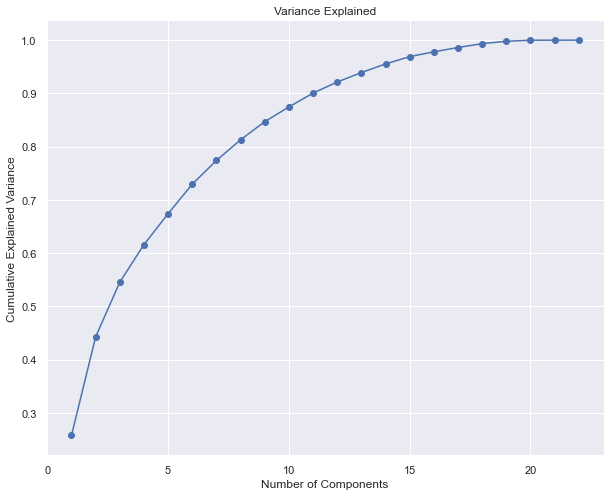

In [4]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data)

pca = PCA()
pca.fit(segmentation_std)
plt.figure(figsize=(10,8))
plt.plot(range(1,23), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='-')
plt.title('Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# select components that VAR higher than 0.8
# here: 7

In [5]:
pca = PCA(n_components=7)
pca.fit(segmentation_std)
scores_pca = pca.transform(segmentation_std)
data_pca = pd.concat([data.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_pca.columns.values[-7: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7']
df = data_pca[['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7']]
df['Date'] = Date
df['Spot price'] = Price
df['Time of day'] = Hours
df.head()

<ipython-input-5-eb85aa4beded>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = Date
<ipython-input-5-eb85aa4beded>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spot price'] = Price
<ipython-input-5-eb85aa4beded>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Date,Spot price,Time of day
0,-1.956469,1.382627,3.169866,-0.560079,0.257157,-1.440357,0.341211,2015/1/1,25.02,0
1,-1.814668,1.235467,3.683082,-0.750284,0.051682,-1.401639,-0.193935,2015/1/1,18.29,1
2,-1.681881,1.128880,4.025885,-0.811245,-0.040673,-1.409877,-0.205372,2015/1/1,16.04,2
3,-1.640356,1.023206,4.169933,-0.955742,-0.133193,-1.390728,-0.507750,2015/1/1,14.60,3
4,-1.646169,1.040397,4.133155,-0.936780,-0.091078,-1.423354,-0.407166,2015/1/1,14.95,4


In [6]:
df.set_index("Date", drop=False, inplace=True)
df.reset_index(drop=True, inplace=True)
lag_features = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7']
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]


df.set_index("Date", drop=False, inplace=True)
df.fillna(df.mean(), inplace=True)
df.head()


<ipython-input-6-fe203258e116>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
<ipython-input-6-fe203258e116>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
<ipython-input-6-fe203258e116>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Date,Spot price,Time of day,...,Component 6_mean_lag30,Component 6_std_lag3,Component 6_std_lag7,Component 6_std_lag30,Component 7_mean_lag3,Component 7_mean_lag7,Component 7_mean_lag30,Component 7_std_lag3,Component 7_std_lag7,Component 7_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2015/1/1,-1.956469,1.382627,3.169866,-0.560079,0.257157,-1.440357,0.341211,2015/1/1,25.02,0,...,-0.000673,0.206624,0.416611,0.806769,-0.000035,-0.000119,-0.000275,0.361787,0.548262,0.714723
2015/1/1,-1.814668,1.235467,3.683082,-0.750284,0.051682,-1.401639,-0.193935,2015/1/1,18.29,1,...,-1.440357,0.206624,0.416611,0.806769,0.341211,0.341211,0.341211,0.361787,0.548262,0.714723
2015/1/1,-1.681881,1.128880,4.025885,-0.811245,-0.040673,-1.409877,-0.205372,2015/1/1,16.04,2,...,-1.420998,0.027377,0.027377,0.027377,0.073638,0.073638,0.073638,0.378405,0.378405,0.378405
2015/1/1,-1.640356,1.023206,4.169933,-0.955742,-0.133193,-1.390728,-0.507750,2015/1/1,14.60,3,...,-1.417291,0.020396,0.020396,0.020396,-0.019365,-0.019365,-0.019365,0.312321,0.312321,0.312321
2015/1/1,-1.646169,1.040397,4.133155,-0.936780,-0.091078,-1.423354,-0.407166,2015/1/1,14.95,4,...,-1.410650,0.009605,0.021301,0.021301,-0.302352,-0.141462,-0.141462,0.177972,0.353071,0.353071


In [7]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

<ipython-input-7-aaf895c467cb>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Date,Spot price,Time of day,...,Component 7_mean_lag3,Component 7_mean_lag7,Component 7_mean_lag30,Component 7_std_lag3,Component 7_std_lag7,Component 7_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015/1/1,-1.956469,1.382627,3.169866,-0.560079,0.257157,-1.440357,0.341211,2015-01-01,25.02,0,...,-0.000035,-0.000119,-0.000275,0.361787,0.548262,0.714723,1,1,1,3
2015/1/1,-1.814668,1.235467,3.683082,-0.750284,0.051682,-1.401639,-0.193935,2015-01-01,18.29,1,...,0.341211,0.341211,0.341211,0.361787,0.548262,0.714723,1,1,1,3
2015/1/1,-1.681881,1.128880,4.025885,-0.811245,-0.040673,-1.409877,-0.205372,2015-01-01,16.04,2,...,0.073638,0.073638,0.073638,0.378405,0.378405,0.378405,1,1,1,3
2015/1/1,-1.640356,1.023206,4.169933,-0.955742,-0.133193,-1.390728,-0.507750,2015-01-01,14.60,3,...,-0.019365,-0.019365,-0.019365,0.312321,0.312321,0.312321,1,1,1,3
2015/1/1,-1.646169,1.040397,4.133155,-0.936780,-0.091078,-1.423354,-0.407166,2015-01-01,14.95,4,...,-0.302352,-0.141462,-0.141462,0.177972,0.353071,0.353071,1,1,1,3


In [8]:
df_train = df[51875:56119] # 改
df_valid = df[56119:56219]

In [9]:
df_temp = df.drop(['Date', 'Time of day', 'Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'month', 'week', 'day',
       'day_of_week'], axis='columns')

In [10]:
# 'Time of day',
exogenous_features = df_temp.columns[df_temp.columns != 'Spot price']


In [11]:
print(exogenous_features)

Index(['Component 1_mean_lag3', 'Component 1_mean_lag7',
       'Component 1_mean_lag30', 'Component 1_std_lag3',
       'Component 1_std_lag7', 'Component 1_std_lag30',
       'Component 2_mean_lag3', 'Component 2_mean_lag7',
       'Component 2_mean_lag30', 'Component 2_std_lag3',
       'Component 2_std_lag7', 'Component 2_std_lag30',
       'Component 3_mean_lag3', 'Component 3_mean_lag7',
       'Component 3_mean_lag30', 'Component 3_std_lag3',
       'Component 3_std_lag7', 'Component 3_std_lag30',
       'Component 4_mean_lag3', 'Component 4_mean_lag7',
       'Component 4_mean_lag30', 'Component 4_std_lag3',
       'Component 4_std_lag7', 'Component 4_std_lag30',
       'Component 5_mean_lag3', 'Component 5_mean_lag7',
       'Component 5_mean_lag30', 'Component 5_std_lag3',
       'Component 5_std_lag7', 'Component 5_std_lag30',
       'Component 6_mean_lag3', 'Component 6_mean_lag7',
       'Component 6_mean_lag30', 'Component 6_std_lag3',
       'Component 6_std_lag7', 'Comp

In [13]:
model = auto_arima(df_train['Spot price'], exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train['Spot price'], exogenous=df_train[exogenous_features])

evidence = model.predict(n_periods=len(df_train), exogenous=df_train[exogenous_features])
df_train["Train_ARIMAX"] = evidence

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26225.330, Time=20.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26934.821, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26706.759, Time=17.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26645.221, Time=17.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26932.837, Time=7.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26265.766, Time=18.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26221.621, Time=17.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26645.658, Time=17.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26558.129, Time=17.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26227.065, Time=18.91 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26439.306, Time=17.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=20.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26193.063, Time=18.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26643.770, Time=17.24 sec
 ARIMA(2,1,0)

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-13-fe6f0dd327a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Train_ARIMAX"] = evidence
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-13-fe6f0dd327a3>:8: SettingWithCopyWarning: 
A value is trying to be set on 

Text(0.5, 1.0, 'Forecast')

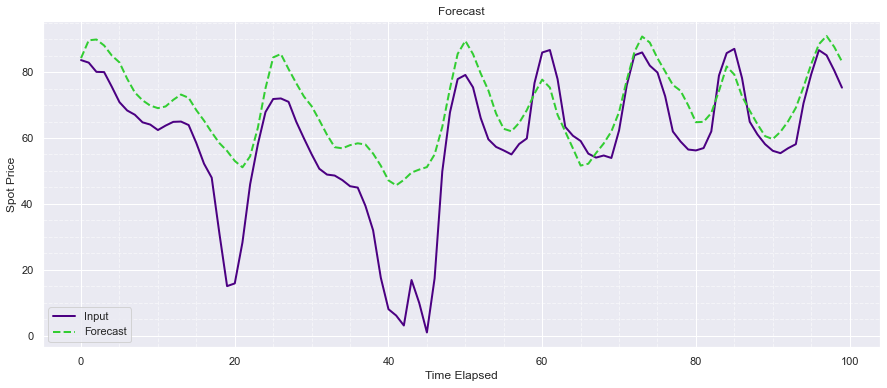

In [14]:
y = df_valid["Forecast_ARIMAX"].tolist()
#print(len(y))

#print(df[df.Date > "2015/12/31"].iloc[:,5])
#x = df[df.Date > "2015/12/31"].iloc[:,5]
x = list(range(0,len(y)))
#print(x)

plt.figure(figsize=(15,6))
plt.rcParams.update({"font.size" : 16})

plt.plot(x, df_valid["Spot price"], '-', color = 'indigo', label = 'Input', linewidth=2)
plt.plot(x, df_valid["Forecast_ARIMAX"],'--', color = 'limegreen', label = 'Forecast', linewidth=2)

#formatting
plt.grid(b=True, which='major', linestyle = 'solid')
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
plt.xlabel("Time Elapsed")
plt.ylabel("Spot Price")
plt.legend()
plt.title("Forecast")

In [15]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid['Spot price'], df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid['Spot price'], df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 15.717633070709617

MAE of Auto ARIMAX: 11.701966283537567


In [16]:
predict = df_valid.Forecast_ARIMAX.tolist()
actual = df_valid['Spot price'].tolist()
print(predict)
print(actual)

[84.26627023039944, 89.68121265226202, 89.92979811681302, 88.11290024015898, 85.0668610304585, 82.96399832882884, 78.01233757517942, 73.83308333666685, 71.45461506922787, 69.85193200480269, 69.07842732957917, 69.58458620544906, 71.59700087514818, 73.20651861700586, 72.20666262835402, 68.46111206959272, 65.28577123705585, 61.719908108586694, 58.4568473831455, 56.07863967250379, 53.037393079574784, 51.1058554389626, 54.44745408915075, 63.07790066381195, 75.13457628503777, 84.48794974596379, 85.51759747787125, 80.94277982395425, 76.6466869905804, 72.60523278173167, 69.66935489900514, 65.44284256447618, 60.99559158710458, 57.218209274121904, 56.86742916849981, 57.83321194746977, 58.39118529753107, 58.02628503599996, 55.276517014966245, 51.599843469808896, 47.130401280324726, 45.62514525322645, 47.27571717963286, 49.51348798223623, 50.41665206447698, 51.16902716512526, 54.99858479658091, 63.38607866198758, 75.02200305109255, 85.54646925513812, 89.51613423218622, 85.48768089133083, 79.611266

In [19]:
from sklearn.metrics import mean_absolute_percentage_error
print(1 - mean_absolute_percentage_error(predict, actual))

0.8087038259476079
